In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import random
import functools
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, r2_score
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

## Auto Encoder
- It is unsupervised deep learning technique for compressing data.
- It uses a Neural Net for compressing data.
- It tries to fit (X, X) to Neural net.
- There is a bottleneck layer in middle whose dimensions is set to the desired number of features in compressed data.
- Neural net tries to capture information such that the output of this layer can reconstruct the data with minimum loss.

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

In [3]:
class layer:
    def __init__(self, output_dim, input_dim, activation_function, derivative):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.activation_function = activation_function
        self.activation_function_derivative = derivative
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(
            2 / input_dim)
        self.b = np.zeros((output_dim, 1))

    def print_layer_detail(self):
        print(
            """Input_dim = {0}, output_dim = {1}, activation_function = {2}, W.shape = {3},
         b.shape = {4}""".format(self.input_dim, self.output_dim,
                                 self.activation_function.__name__,
                                 self.W.shape, self.b.shape))


class NeuralNetwork:
    def __init__(self, iterations=10, alpha=0.01, batch_size=50):
        self.layers = []
        self.iterations = iterations
        self.alpha = alpha
        self.epsilon = 1e-11
        self.batch_size = batch_size
        self.no_of_layers = 0
        self.input_activation = self.linear

    def add_input_activation(self, activation="linear"):
        if activation == "relu":
            input_activation = self.relu
        elif activation == "sigmoid":
            input_activation = self.sigmoid
        elif activation == "tanh":
            input_activation = self.tanh
        elif activation == "softmax":
            input_activation = self.softmax
        elif activation == "linear":
            input_activation = self.linear
        else:
            raise ("Not a valid error function")
            return

    def change_iterations(self, iterations):
        self.iterations = iterations

    def change_alpha(self, alpha):
        self.alpha = alpha

    def sigmoid(self, z):
        s = 1 / (1 + np.exp(-z))
        return s

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        s = s * (1 - s)
        return s

    def relu(self, z):
        #         print(z)
        s = np.maximum(0, z)
        return s

    def linear(self, z):
        return z

    def linear_derivative(self, z):
        return np.ones((z.shape))

    def relu_derivative(self, z):
        s = (z > 0)
        #z[z >= 0] = 1
        #z[z < 0] = 0
        s = s.astype('int')
        assert (s.shape == z.shape)
        return s

    def tanh(self, z):
        return np.tanh(z)

    def tanh_derivative(self, z):
        return (1 - np.square(np.tanh(z)))

    def softmax(self, z):
        z = z - z.max(axis=0, keepdims=True)
        y = np.exp(z)
        y = np.nan_to_num(y)
        y = y / y.sum(axis=0, keepdims=True)
        return y

    def softmax_derivative(self, z):
        print(z.shape)
        z = z - z.max(axis=0, keepdims=True)
        y = np.exp(z)
        y = (y * (y.sum(axis=0, keepdims=True) - y)) / np.square(
            y.sum(axis=0, keepdims=True))
        return y

    def standardize(self, X):
        X_standardized = (X - self.mean) / self.std
        #         display(X_standardized, X_standardized.shape)
        return X_standardized

    def add_layer(self, output_dim, input_dim, activation="relu"):
        activation_function = None
        derivative = None
        if activation == "relu":
            activation_function = self.relu
            derivative = self.relu_derivative
        elif activation == "sigmoid":
            activation_function = self.sigmoid
            derivative = self.sigmoid_derivative
        elif activation == "tanh":
            activation_function = self.tanh
            derivative = self.tanh_derivative
        elif activation == "softmax":
            activation_function = self.softmax
            derivative = self.softmax_derivative
        elif activation == "linear":
            activation_function = self.linear
            derivative = self.linear_derivative
        else:
            raise ("Not a valid error function")
            return
        new_layer = layer(output_dim, input_dim, activation_function,
                          derivative)
        if len(self.layers) == 0:
            self.input_shape = input_dim
        self.output_shape = output_dim
        self.layers.append(new_layer)
        self.no_of_layers += 1

    def fit(self, X, y):
        self.mean, self.std = X.mean(), X.std()
        X = self.standardize(X)
        y = self.standardize(y)
        X = np.array(X).T
        y = np.array(y).T
        assert (X.shape[0] == self.input_shape)
        assert (y.shape[0] == self.output_shape)
        assert (X.shape[1] == y.shape[1])
        m = X.shape[1]
        costs = []

        #### X.shape = (number_of_features, number_of_rows)
        #### y.shape = (number_of_labels, number_of_rows)
        full_X = X.T
        full_y = y.T
        for i in range(self.iterations):
            p = np.random.permutation(m)
            full_X, full_y = full_X[p], full_y[p]
            #             print("Iteration Number: ", i + 1)
            start = 0
            end = self.batch_size
            xxx = 2 * m / (self.batch_size * 3)
            while end <= m:
                X = full_X.T[:, start:end]
                y = full_y.T[:, start:end]
                start += self.batch_size
                end += self.batch_size
                if end % xxx == 0:
                    print("#", end='')
            #### Forward Propogation
                A = X
                A = self.input_activation(A)
                for layer_no in range(len(self.layers)):
                    A = self.forward_propogation(layer_no, A)
#                 A = np.nan_to_num(A)
#                 A = A / A.sum(axis=0, keepdims=True)
#                 print(max(A.sum(axis = 1)))
#### A.shape = (number_of_labels, number_of_rows)
                dA = self.compute_error(A, y)
                #                 W = self.layers[-1].W
                #                 A = self.layers[-1].A
                #                 dW = np.dot(dZ, A.T) / m
                #                 #### shape of db = (output_dim, 1)
                #                 db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
                #                 #### shape of da_new = ((input_dim, output_dim)*(output_dim, number_of_rows))
                #                 #### shape of da_new = (input_dim, number_of_rows)
                #                 dA = np.dot(W.T, dZ)
                #                 #         print("da_new.shape = {0}".format(da_new.shape))
                #                 self.layers[-1].dW = dW
                #                 self.layers[-1].db = db
                #### Backward Propogation
                for layer_no in range(len(self.layers) - 1, -1, -1):
                    dA = self.backward_propogation(layer_no, dA)

                #### Update parameters

                for layer_no in range(len(self.layers)):
                    self.update_parameters(i, layer_no)

            A = full_X.T
            A = self.input_activation(A)
            for layer_no in range(len(self.layers)):
                A = self.forward_propogation(layer_no, A)
            cost = self.compute_cost(A, full_y.T)
            costs.append(cost)
#             print()
        return costs
        iteration_list = [i for i in range(1, len(costs) + 1)]
        plt.style.use('fivethirtyeight')
        plt.plot(iteration_list, costs)
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        plt.show()
#         display(costs)

    def forward_propogation(self, layer_no, A):
        #         print("########################################")
        #         print(layer_no)
        #         print(self.layers[layer_no].W)
        #         display("Layer number {0}".format(layer_no))
        self.layers[layer_no].A = A
        #### shape of A = (input_dim, number of rows)
        #### shape of W = (output_dim, input_dim)
        W = self.layers[layer_no].W
        b = self.layers[layer_no].b
        #### shape of b = (output_dim, 1)
        g = self.layers[layer_no].activation_function
        self.layers[layer_no].Z = np.dot(W, A) + b
        #### shape of Z = (output_dim, number_of_rows)
        A = g(self.layers[layer_no].Z)
        #### shape of A = (output_dim, number_of_rows)
        return A

    def compute_cost(self, prediction, target):
        #         display(y_hat.max())
        # shape of prediction (number_of_labels, number of training rows)
        cost = np.mean(np.square(prediction - target))
        return cost

    def compute_error(self, prediction, target):
        m = prediction.shape[1]
        return (1 / m) * (prediction - target)
#         denominator = np.maximum(prediction - prediction**2, self.epsilon)
#         delta = (prediction - target) / denominator
#         #         delta = -np.nan_to_num(np.divide(target, prediction)) + np.nan_to_num(np.divide(1-target, 1-prediction))
#         assert (delta.shape == target.shape == prediction.shape)
#         return delta

    def backward_propogation(self, layer_no, dA):
        #### shape of dA = (output_dim, number_of_rows)
        #### shape of W = (output_dim, input_dim)
        #### shape of Z = (output_dim, number_of_rows)
        #### shape of A = (input_dim, number_of_rows)
        W = self.layers[layer_no].W
        g_der = self.layers[layer_no].activation_function_derivative
        Z = self.layers[layer_no].Z
        A = self.layers[layer_no].A
        m = A.shape[1]
        #### shape of dZ = (output_dim, number_of_rows)
        #         print(
        #             "dA.shape = {0}, Z.shape = {1}, activation_function = {2}".format(
        #                 dA.shape, Z.shape, g_der.__name__))
        dZ = dA * g_der(Z)
        #### shape of dW = ((output_dim, number_of_rows)*(number_of_rows, input_dim))
        #### shape of dW = (output_dim, input_dim)
        dW = np.dot(dZ, A.T) / m
        #### shape of db = (output_dim, 1)
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        #### shape of da_new = ((input_dim, output_dim)*(output_dim, number_of_rows))
        #### shape of da_new = (input_dim, number_of_rows)
        da_new = np.dot(W.T, dZ)
        #         print("da_new.shape = {0}".format(da_new.shape))
        self.layers[layer_no].dW = dW
        self.layers[layer_no].db = db
        self.layers[layer_no].A = self.layers[layer_no].Z = None
        return da_new

    def update_parameters(self, iteration, layer_no):
        #### shape of W, dW = (output_dim, input_dim)
        #### shape of b, db = (output_dim, 1)
        W = self.layers[layer_no].W
        b = self.layers[layer_no].b
        dW = self.layers[layer_no].dW
        db = self.layers[layer_no].db
        alph = self.alpha / (1 + iteration)
        W = W - alph * dW
        b = b - alph * db
        self.layers[layer_no].W = W
        self.layers[layer_no].b = b
        self.layers[layer_no].dW = self.layers[layer_no].db = None


#         display("W", W)
#         display("b", b)

    def predict(self, X, start_layer=0, end_layer=None):
        if end_layer is None:
            end_layer = self.no_of_layers
        A = None

        if start_layer == 0:
            X = np.array(self.standardize(X))
            X = np.array(X).T
            A = self.input_activation(X)
        else:
            A = np.array(X).T
        for layer_no in range(start_layer, end_layer):
            A = self.forward_propogation(layer_no, A)
        A = A.T
        #         for i in range(len(A)):
        #             display(A[i])
        return A

## Class Auto Encoder
- It is using previously implemented neural network.
- Add layer function is adding layer to neural network. It also takes a boolean bottleneck variable.
- Fit trains the neural network. 
- Encode and Decode are restricted forward propogations on the Neural Network.
- Encode is forward prop from starting layer till the bottleneck layer.
- Decode is backward prop from bottleneck layer till last layer.
- Compute reconstruction loss is computing reconstruction loss.

In [4]:
class AutoEncoder:
    def __init__(self, input_activation="linear"):
        self.NN = NeuralNetwork(iterations=40)
        self.NN.add_input_activation(input_activation)

    def add_layer(self,
                  output_dim,
                  input_dim,
                  activation="relu",
                  bootleneck_layer=False):
        self.NN.add_layer(output_dim, input_dim, activation)
        if bootleneck_layer:
            self.bootleneck_layer = self.NN.no_of_layers

    def fit(self, X):
        return self.NN.fit(X, X)

    def encode(self, X):
        result = self.NN.predict(X, 0, self.bootleneck_layer)
        return pd.DataFrame(result)

    def decode(self, X):
        result = self.NN.predict(X, self.bootleneck_layer)
        return pd.DataFrame(result)

    def compute_reconstruction_loss(self, X, X_prime):
        X = self.NN.standardize(X)
        return self.NN.compute_cost(np.array(X), np.array(X_prime))

    def print_layer(self):
        for layer in self.NN.layers:
            layer.print_layer_detail()

In [18]:
class VanillaEncoder(AutoEncoder):
    def __init__(self,
                 input_dim,
                 output_dim,
                 input_activation="linear",
                 bottleneck_activation="linear",
                 output_activation="linear"):
        super(VanillaEncoder, self).__init__(input_activation)
        self.add_layer(output_dim, input_dim, bottleneck_activation, True)
        self.add_layer(input_dim, output_dim, output_activation)

In [16]:
data = pd.read_csv("data.csv")
X = data.drop(['xAttack'], axis=1)
print(X.shape)

(24998, 29)


## Vanilla Encoder input and output layer has linear activation function

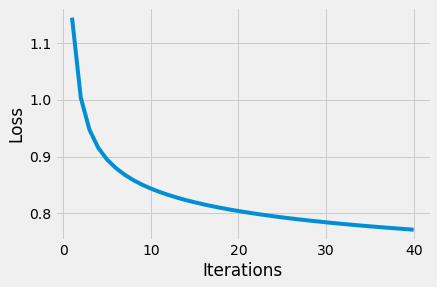

In [6]:
linear_vanilla = VanillaEncoder(29, 14, bottleneck_activation="relu")
linear_vanilla.fit(X)

In [7]:
reduced_data = linear_vanilla.encode(X)
reconstructed_data = linear_vanilla.decode(reduced_data)
error = linear_vanilla.compute_reconstruction_loss(X, reconstructed_data)
print(error)

0.7713330110173735


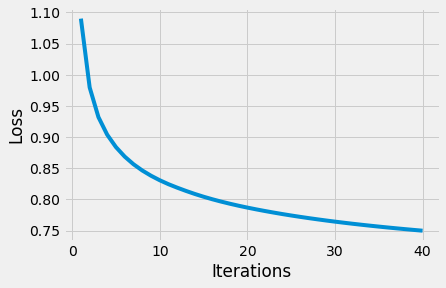

In [8]:
non_linear_vanilla = VanillaEncoder(
    29,
    14,
    bottleneck_activation="relu",
    input_activation="relu",
    output_activation="relu")
non_linear_vanilla.fit(X)

In [9]:
reduced_data = non_linear_vanilla.encode(X)
reconstructed_data = non_linear_vanilla.decode(reduced_data)
error = non_linear_vanilla.compute_reconstruction_loss(X, reconstructed_data)
print(error)

0.7498065334823116


In [5]:
def run_deep_encoder(activation="relu"):
    deep_encoder = AutoEncoder("linear")
    deep_encoder.add_layer(64, 29, activation=activation, bootleneck_layer=False)
    deep_encoder.add_layer(128, 64, activation=activation, bootleneck_layer=False)
    deep_encoder.add_layer(14, 128, activation=activation, bootleneck_layer=True)
    deep_encoder.add_layer(64, 14, activation=activation, bootleneck_layer=False)
    deep_encoder.add_layer(128, 64, activation=activation, bootleneck_layer=False)
    deep_encoder.add_layer(29, 128, activation=activation, bootleneck_layer=False)
    cost = deep_encoder.fit(X)
    reduced_data = deep_encoder.encode(X)
    reconstructed_data = deep_encoder.decode(reduced_data)
    error = deep_encoder.compute_reconstruction_loss(X, reconstructed_data)
    print("For {0} activation error is {1}".format(activation, error))
    return cost

In [11]:
activation = "tanh"
deep_encoder = AutoEncoder("linear")
deep_encoder.add_layer(64, 29, activation=activation, bootleneck_layer=False)
deep_encoder.add_layer(128, 64, activation=activation, bootleneck_layer=False)
deep_encoder.add_layer(14, 128, activation=activation, bootleneck_layer=True)
deep_encoder.add_layer(64, 14, activation=activation, bootleneck_layer=False)
deep_encoder.add_layer(128, 64, activation=activation, bootleneck_layer=False)
deep_encoder.add_layer(29, 128, activation=activation, bootleneck_layer=False)

In [21]:
X = np.random.rand(1, 29)
deep_encoder.fit(X)
display(X)
X_encoded = deep_encoder.encode(X)
display(X_encoded)
X_decoded = deep_encoder.decode(X_encoded)
display(X_decoded)

array([[0.85611107, 0.86724284, 0.3519957 , 0.01033503, 0.90112175,
        0.80912876, 0.75145995, 0.91945156, 0.54112838, 0.81425001,
        0.19420407, 0.29588642, 0.59134767, 0.93620472, 0.38283879,
        0.92113598, 0.13712681, 0.96473897, 0.04245164, 0.21791974,
        0.12431855, 0.85971732, 0.74082304, 0.14634297, 0.74125127,
        0.2037555 , 0.02406316, 0.9384585 , 0.83743105]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.844591,-0.921093,0.374201,-0.152369,0.039926,-0.092883,0.317283,-0.177326,0.928025,0.92688,0.272083,-0.792554,0.932133,0.623851


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.763278,-0.394598,0.959596,0.578094,-0.754316,0.418802,0.297805,0.166463,-0.73554,-0.225528,...,0.67988,-0.002812,0.834878,-0.581776,-0.411445,0.958012,0.825726,-0.66512,-0.725766,-0.807133


For relu activation error is 0.6915600696409082
For sigmoid activation error is 1.0659237369058103
For tanh activation error is 0.5879335229344151


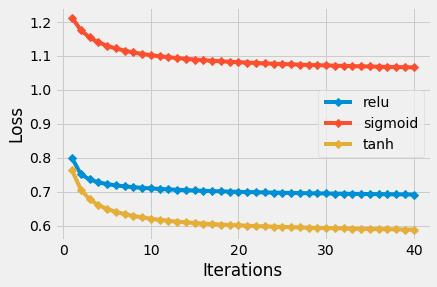

In [24]:
activations = ["relu", "sigmoid", "tanh"]
for activation in activations:
    costs = run_deep_encoder(activation)
    iteration_list = [i for i in range(1, len(costs) + 1)]
    plt.style.use('fivethirtyeight')
    plt.plot(iteration_list, costs,"-D", label=activation)
    plt.legend(loc="best")
    plt.ylabel("Loss")
    plt.xlabel("Iterations")
plt.show()

In [30]:
def convert_categorical_to_numerical(data):
    res = pd.factorize(data)
    x, y = res
    return x, y
reduced_data['xAttack'] = data['xAttack']
array, convert_back_attack_to_categorical = convert_categorical_to_numerical(
    reduced_data['xAttack'])
reduced_data['xAttack'] = array

In [35]:
class Cluster:
    def __init__(self, X):
        self.points = None
        self.mean = X
        self.count = 0
        self.change = True

    def add_point(self, X):
        if self.points is None:
            self.points = np.array(X)
            self.points = np.reshape(self.points, (1, -1))
        else:
            self.points = np.vstack([self.points, X])
        self.count += 1

    def delete_point(self):
        if self.points is None:
            return
        if len(self.points) == 1:
            self.points = None
        x = self.points[-1]
        self.points = self.points[:-1]
        self.count -= 1
        return x

    def calculate_mean(self):
        new_mean = np.mean(self.points, axis=0)
        if (new_mean == self.mean).all:
            self.change = False
        else:
            self.change = True
        self.mean = new_mean

    def label(self):
        val, count = np.unique(self.points[:, -1], return_counts=True)
        return val[np.argmax(count)]

    def purity(self):
        val, count = np.unique(self.points[:, -1], return_counts=True)
        return (100.0 * np.max(count)) / np.sum(count)

    def clear_cluster(self):
        self.points = None
        self.count = 0

    def return_class_distribution(self):
        val, count = np.unique(self.points[:, -1], return_counts=True)
        return val, count

    def maximum_count(self):
        val, count = np.unique(self.points[:, -1], return_counts=True)
        return np.max(count)
    
    def plot_pie(self, labels):
        val, count = np.unique(self.points[:, -1], return_counts=True)
        labels = [labels[i] for i in val]
        #         print(val, count)
        sizes = [i / np.sum(count) for i in count]
        fig1, ax1 = plt.subplots()
        ax1.pie(
            sizes,
            labels=labels,
            autopct='%1.1f%%',
            shadow=True,
            startangle=90)
        ax1.axis('equal'
                 )  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.legend(loc="best")
        plt.style.use('fivethirtyeight')
        plt.show()
        
class KMeans:
    def __init__(self, k):
        self.k = k
        self.clusters = []

    def euclid(self, x_point, mean_point):
        dis = np.sum([(x - y)**2 for x, y in zip(x_point, mean_point)])
        dis -= (x_point[-1] - mean_point[-1])**2
        return np.sqrt(dis)

    def make_non_zero_cluster(self, index):
        non_zero_cluster = 0
        for i in range(self.k):
            if self.clusters[i].count > 1:
                non_zero_cluster = i
                break
        random_point = self.clusters[non_zero_cluster].delete_point()
        self.clusters[index].add_point(random_point)

    def fit(self, data, iterations=10):
        random_indexes = random.sample(range(0, len(data)), self.k)
        data = np.array(data)
        for i in random_indexes:
            self.clusters.append(Cluster(data[i]))
        for iteration in range(iterations):
            for i in range(len(self.clusters)):
                self.clusters[i].clear_cluster()
            for row in data:
                distances = np.array(
                    [self.euclid(row, x.mean) for x in self.clusters])
                self.clusters[np.argmax(distances)].add_point(row)
            for i in range(self.k):
                if self.clusters[i].count == 0:
                    self.make_non_zero_cluster(i)
                    self.clusters[i].change = True
                self.clusters[i].calculate_mean()
            change = functools.reduce(lambda a, d: a or d,
                                      [i.change for i in self.clusters], False)
            if not change:
                break

    def print_purity(self):
        for i, cluster in enumerate(self.clusters):
            print("i = {0}, count = {1}, purity = {2}, label = {3} ".format(
                i, cluster.count, cluster.purity(), cluster.label()))

    def purity(self):
        pure_class_count = np.sum([i.maximum_count() for i in self.clusters])
        total_count = np.sum([len(i.points) for i in self.clusters])
        return (100.0*pure_class_count/total_count)

    def plot_pie_chart(self, labels):
        for cluster in self.clusters:
            cluster.plot_pie(labels)

In [36]:
K_means_clustering = KMeans(5)
K_means_clustering.fit(reduced_data)
K_means_clustering.purity()

81.89855188415073

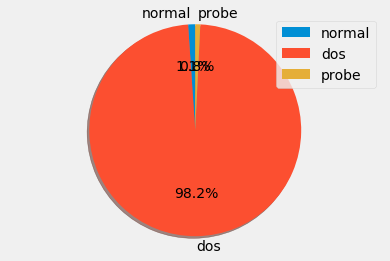

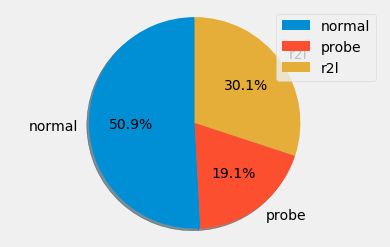

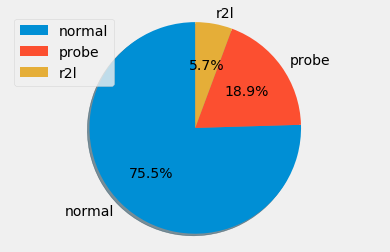

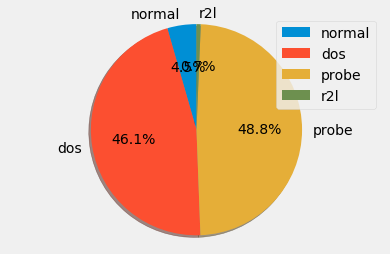

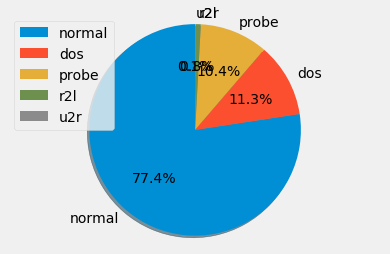

In [37]:
K_means_clustering.plot_pie_chart(convert_back_attack_to_categorical)

In [38]:
gmm = GaussianMixture(n_components=5)
gmm.fit(reduced_data.drop('xAttack', 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [39]:
def euclid(x_point, mean_point):
    #     print(x_point.shape, mean_point.shape)
    dis = np.sum([(x - y)**2 for x, y in zip(x_point, mean_point)])
    return np.sqrt(dis)

i = 0, count = 6175, purity = 60.63157894736842, label = 0.0 


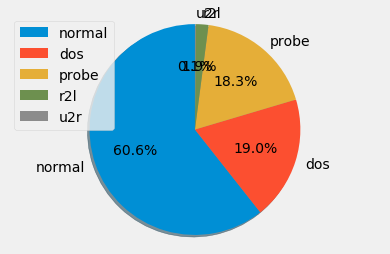

i = 1, count = 10439, purity = 90.04693936200786, label = 0.0 


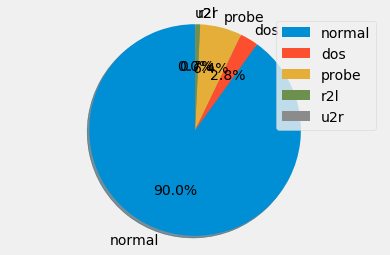

i = 2, count = 2059, purity = 64.74016512870325, label = 1.0 


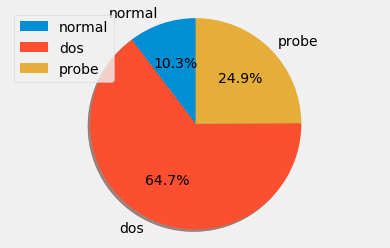

i = 3, count = 6317, purity = 100.0, label = 1.0 


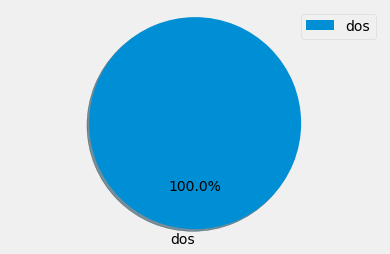

i = 4, count = 8, purity = 87.5, label = 0.0 


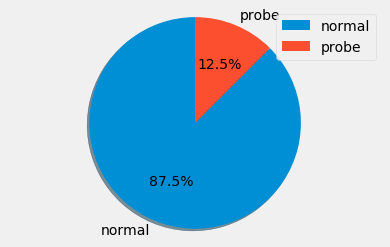

In [40]:
clusters = [Cluster(x) for x in gmm.means_]
reduced_data_np = np.array(reduced_data)
for row in reduced_data_np:
    probs = gmm.predict_proba([row[:-1]])
    clusters[np.argmax(probs)].add_point(row)
for i, cluster in enumerate(clusters):
    print("i = {0}, count = {1}, purity = {2}, label = {3} ".format(
        i, cluster.count, cluster.purity(), cluster.label()))
    cluster.plot_pie(convert_back_attack_to_categorical)

## Part 4: Hierarchical clustering

i = 0, count = 24989, purity = 53.46352395053824, label = 0 


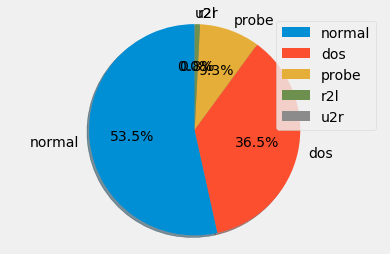

i = 1, count = 6, purity = 66.66666666666667, label = 3 


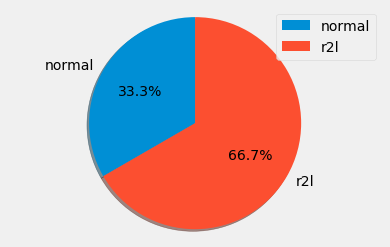

i = 2, count = 1, purity = 100.0, label = 0 


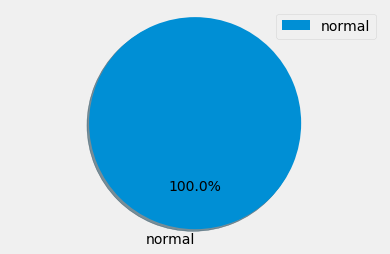

i = 3, count = 1, purity = 100.0, label = 2 


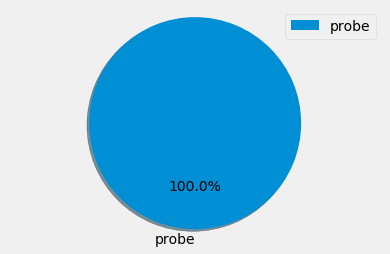

i = 4, count = 1, purity = 100.0, label = 0 


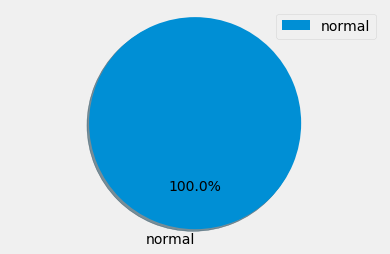

In [41]:
clusters = [Cluster(None) for x in range(5)]
cluster = AgglomerativeClustering(
    n_clusters=5, affinity='euclidean', linkage='single')
cluster_return = cluster.fit_predict(reduced_data.drop('xAttack', 1))
lla = reduced_data['xAttack'].values
for entry, label in zip(cluster_return, lla):
    clusters[entry].add_point(label)
for i, cluster in enumerate(clusters):
    print("i = {0}, count = {1}, purity = {2}, label = {3} ".format(
        i, cluster.count, cluster.purity(), cluster.label()))
    cluster.plot_pie(convert_back_attack_to_categorical)

# Question2

In [29]:
class PCA:
    def standardize(self, X):
        X_standardized = (X - self.mean) / self.std
        return X_standardized

    def find_eigen_pairs(self, X):
        self.mean, self.std = X.mean(), X.std()
        X = self.standardize(X)
        X = np.array(X)
        self.mean_vec = np.mean(X, axis=0)
        conv_mat = X.T.dot(X)
        #         print(conv_mat)
        eigen_values, eigen_vectors = np.linalg.eig(conv_mat)
        tot = sum(eigen_values)
        eigen_values = [(i / tot) * 100 for i in eigen_values]
        eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i])
                       for i in range(len(eigen_values))]
        eigen_pairs.sort(key=lambda x: x[0], reverse=True)
        self.eigen_pairs = eigen_pairs

    def reduce_dimension(self, X, percent=90, dimensions = None):
        X = np.array(self.standardize(X))
        num_dimension = 0
        eigen_values = np.array([i[0] for i in self.eigen_pairs])
        eigen_values = np.cumsum(eigen_values)
        for index, percentage in enumerate(eigen_values):
            if percentage > percent:
                num_dimension = index + 1
                break
        if dimensions is not None:
            num_dimension = dimensions
        num_features = X.shape[1]
        proj_mat = self.eigen_pairs[0][1].reshape(num_features, 1)
        for eig_vec_index in range(1, num_dimension):
            proj_mat = np.hstack((proj_mat,
                                  self.eigen_pairs[eig_vec_index][1].reshape(
                                      num_features, 1)))
        self.proj_mat = proj_mat
        pca_data = X.dot(proj_mat)
        return pd.DataFrame(pca_data)

    def reconstruct(self, X):
        X = np.array(X)
        X_reconstructed = X.dot(self.proj_mat.T)
        return pd.DataFrame(X_reconstructed)

    def euclid(self, test_row, train_row):
        dis = np.sqrt(
            np.sum([(x - y)**2 for x, y in zip(test_row, train_row)]))
        return dis

    def find_error(self, X_original, X_reconstructed):
        X_original = self.standardize(X_original)
        X_original = np.array(X_original)
        X_reconstructed = np.array(X_reconstructed)
        error = np.sum([
            self.euclid(x, y) for x, y in zip(X_original, X_reconstructed)
        ])
        print(error)
        error /= (2 * X_original.shape[0])
        return error

In [30]:
digits = load_digits()

In [31]:
def reduced_dimensions(data, dimension=16):
    reducer = PCA()
    data = digits['data']
    reducer.find_eigen_pairs(data)
    reduced_data = reducer.reduce_dimension(data, dimensions = dimension)
    return reducer, reduced_data

## Part1

In [32]:
def KDE_with_grid_search(data):
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(data) 
    print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    kde = grid.best_estimator_
    return kde

In [39]:
def create_and_plot_data(generator, pca,x=False):
    new_data = generator.sample(44)
    if x:
        new_data = new_data[0]
    new_data = pca.reconstruct(new_data)
    new_data = np.array(new_data)
    # turn data into a 4x11 grid
    new_data = new_data.reshape((4, 11, -1))

    # plot real digits and resampled digits
    fig, ax = plt.subplots(4, 11, subplot_kw=dict(xticks=[], yticks=[]))
    for j in range(11):
        for i in range(4):
            im = ax[i, j].imshow(new_data[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
#             im.set_clim(0, 16)
    ax[0, 5].set_title('"New" digits drawn from the model')
    plt.show()

In [40]:
def run_kde_for_params(data, dimension=16):
    pca, reduced_data = reduced_dimensions(data, dimension)
    kde = KDE_with_grid_search(reduced_data)
    create_and_plot_data(kde, pca)

## Part2

In [41]:
def GMM_ewith_BIC(data):
    n_components = np.arange(50, 210, 10)
    models = [GaussianMixture(n, covariance_type='full', random_state=0)
              for n in n_components]
    bics = np.array([model.fit(data).bic(data) for model in models])
    models[np.argmin(bics)].fit(data)
    return models[np.argmax(bics)]

In [42]:
def run_gmm_for_params(data, dimension=16):
    pca, reduced_data = reduced_dimensions(data, dimension)
    gmm = GMM_ewith_BIC(reduced_data)
    create_and_plot_data(gmm, pca, True)

## Part 3

In [43]:
def generate_digits(dims=[16,28,40]):
    for dim in dims:
        print("KDE, number of dimensions: ", dim)
        run_kde_for_params(digits['data'], dim)
        print("GMM, number of dimensions: ", dim)
        run_gmm_for_params(digits['data'], dim)

KDE, number of dimensions:  16


/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best bandwidth: 0.5455594781168519


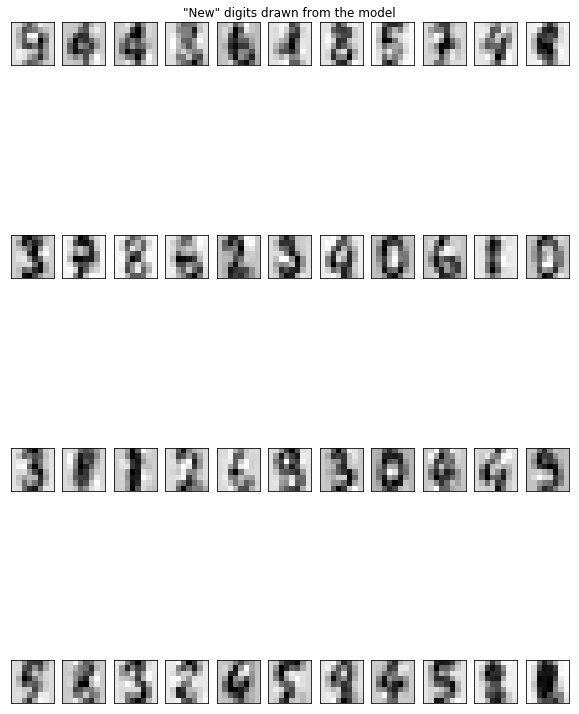

GMM, number of dimensions:  16


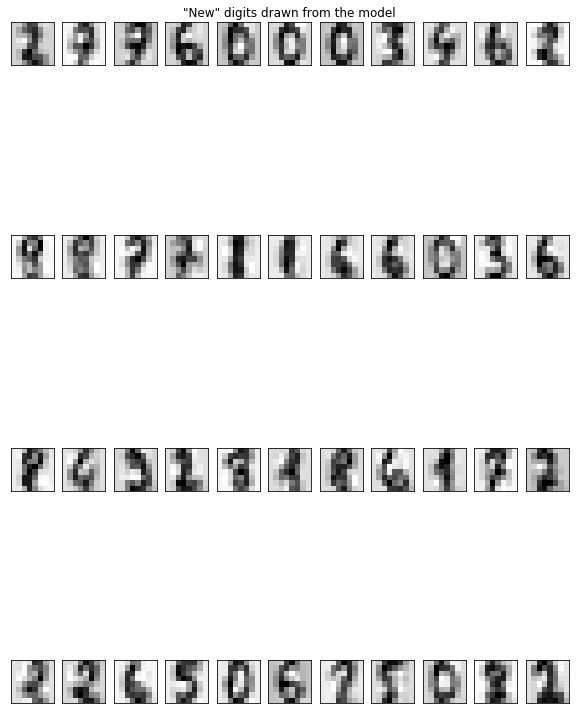

KDE, number of dimensions:  28
best bandwidth: 0.5455594781168519


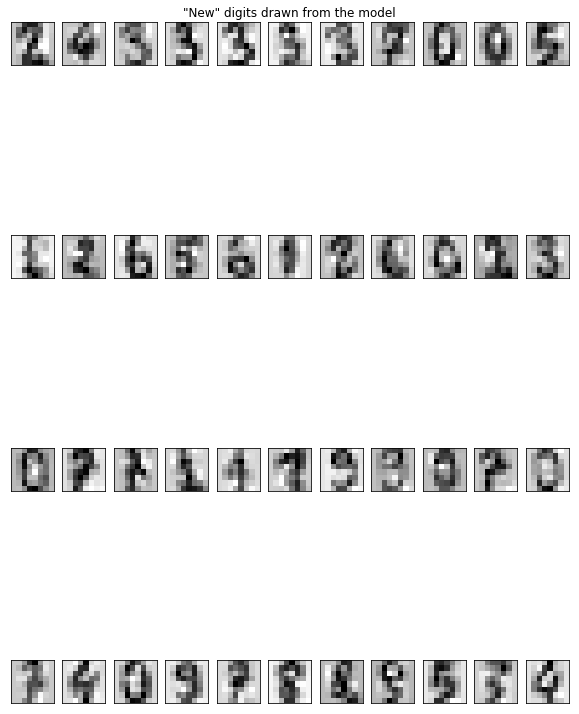

GMM, number of dimensions:  28


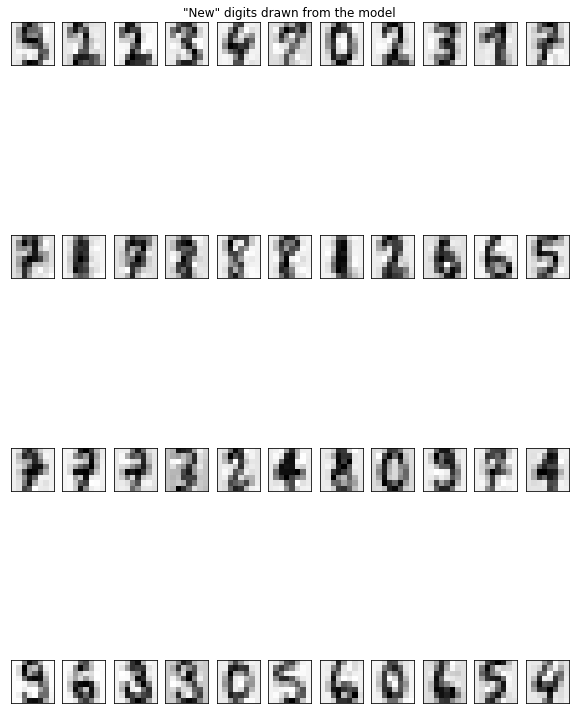

KDE, number of dimensions:  40
best bandwidth: 0.42813323987193935


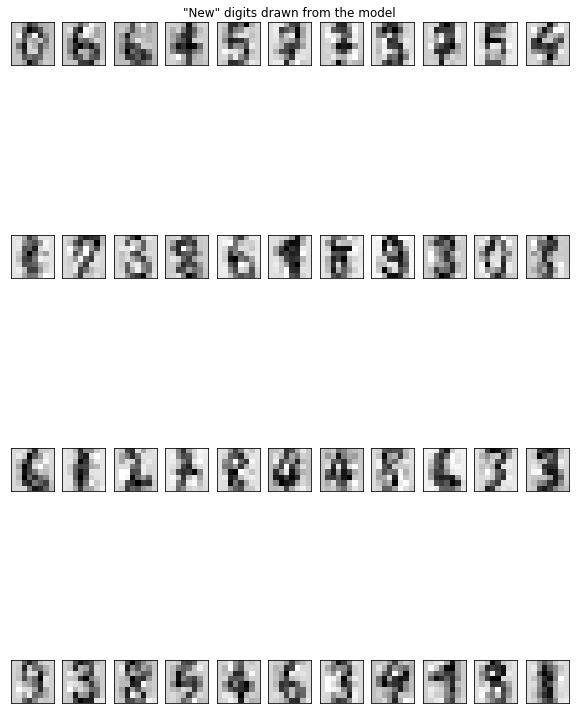

GMM, number of dimensions:  40


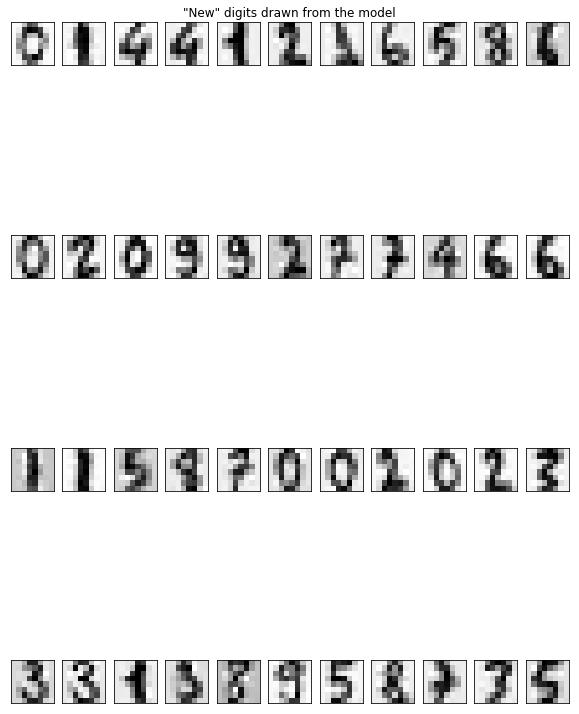

In [44]:
generate_digits()